# EPFL Machine Learning Higgs

## Loading and preprocessing

In [1]:
import math
%load_ext autoreload
%autoreload 2

import os
import csv
import numpy as np
from helpers import load_data, one_hot_encode, standardize

In [2]:
data_directory = '../data'
train_dataset_path = os.path.join(data_directory, 'train.csv')
public_test_dataset_path = os.path.join(data_directory, 'test.csv')

# Loading the data
_, Y_train_public, feature_names, X_train_public = load_data(train_dataset_path)
ids_test_public, _, _, X_test_public = load_data(public_test_dataset_path)

In [3]:
# We need to deal with -999 somehow (missing values)
# First of all, we make sure they do not contribute to computing the mean and std
# Since they are floats, we add an epsilon against numerical errors
EPSILON = 1E-4
mask_train = np.abs(X_train_public + 999) <= EPSILON
mask_test = np.abs(X_test_public + 999) <= EPSILON

print('Proportion of missing values:', np.sum(mask_train)/(mask_train.shape[0]*mask_train.shape[1]))
print('Proportion of missing values:', np.sum(mask_test)/(mask_test.shape[0]*mask_test.shape[1]))

Proportion of missing values: 0.2106736
Proportion of missing values: 0.21050064702935506


In [4]:
# We will standardize the data based on the mean and standard deviation of the public train dataset
# It ignores NaN values for computing the mean and std for the standardization
# ! The method standardizes in-place !
continuous_column_idxs = np.where(feature_names != "PRI_jet_num")[0]
column_means, column_stds = standardize(X_train_public, continuous_column_idxs)
_, _ = standardize(X_test_public, continuous_column_idxs, column_means, column_stds)

# Finally, we set the NaNs to the mean of the standardized dataset, namely, 0
X_train_public = np.nan_to_num(X_train_public, nan=0.0)
X_test_public = np.nan_to_num(X_test_public, nan=0.0)

In [5]:
# We will need to add interaction terms to deal with co-linearity somewhere (like x1*x2 instead of just x1 and x2)


In [6]:
# Then we will need to notice the discrete-valued column, since this needs to be one-hot encoded
# In our dataset, only "PRI_jet_num" is discrete.
discrete_column_idxs = np.where(feature_names == "PRI_jet_num")[0]

# Update the features by one-hot encoding the discrete ones, but only update the feature names at the end
# They will be the same for the train and test set anyway
X_train_public, _ = one_hot_encode(X_train_public, discrete_column_idxs, feature_names)
X_test_public, feature_names = one_hot_encode(X_test_public, discrete_column_idxs, feature_names)

In [7]:
# Since this is a binary classification problem, we do not need to one-hot encode the y-vector, but we can just use binary values
positive_sample = 'b'
negative_sample = 's'
Y_train_public = np.expand_dims((Y_train_public == positive_sample).astype(np.int32), axis=1)

# ! There are quite some more positive than negative samples, maybe we could try to weigh negative samples more or something? !
print('Number of positive samples:', np.sum(Y_train_public))
print('Number of negative samples:', len(Y_train_public) - np.sum(Y_train_public))

Number of positive samples: 164333
Number of negative samples: 85667


# Training and analysis

After preprocessing, the new features of the public train- and test dataset are stored in "X_train_public" and "X_test_public". The labels are binary values stored in "Y_train_public". Furthermore, the feature column names are found in "feature_names"

In [8]:
# We will do k-fold cross validation to create subsets of the training and testing datasets
print(feature_names)
print(X_train_public.shape, X_test_public.shape)
print(Y_train_public.shape)

['DER_mass_MMC' 'DER_mass_transverse_met_lep' 'DER_mass_vis' 'DER_pt_h'
 'DER_deltaeta_jet_jet' 'DER_mass_jet_jet' 'DER_prodeta_jet_jet'
 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt' 'DER_pt_ratio_lep_tau'
 'DER_met_phi_centrality' 'DER_lep_eta_centrality' 'PRI_tau_pt'
 'PRI_tau_eta' 'PRI_tau_phi' 'PRI_lep_pt' 'PRI_lep_eta' 'PRI_lep_phi'
 'PRI_met' 'PRI_met_phi' 'PRI_met_sumet' 'PRI_jet_leading_pt'
 'PRI_jet_leading_eta' 'PRI_jet_leading_phi' 'PRI_jet_subleading_pt'
 'PRI_jet_subleading_eta' 'PRI_jet_subleading_phi' 'PRI_jet_all_pt'
 'PRI_jet_num_0' 'PRI_jet_num_1' 'PRI_jet_num_2' 'PRI_jet_num_3']
(250000, 33) (568238, 33)
(250000, 1)


In [9]:
from helpers import train_test_split
# Now we can do some training
from implementations import reg_logistic_regression

X_train, X_test, Y_train, Y_test = train_test_split(X_train_public, Y_train_public, train_proportion=0.01)

w, loss = reg_logistic_regression(Y_train, X_train, lambda_=0, initial_w=np.zeros(shape=(X_train.shape[1], 1)), max_iters=100000, gamma=0.1)
print('GD loss:', loss)
print('Weights:', w)

100%|██████████| 100000/100000 [00:27<00:00, 3610.63it/s]

GD loss: 0.47307786415893044
Weights: [[-0.25026256]
 [ 0.68146875]
 [ 1.25822315]
 [-0.53250729]
 [ 0.61191617]
 [-1.49270116]
 [ 0.65302671]
 [-1.19246106]
 [-0.01641645]
 [-0.02090222]
 [ 0.47439846]
 [-0.26971056]
 [ 0.48901681]
 [-0.94884552]
 [-0.0200392 ]
 [ 0.08055388]
 [-0.99767106]
 [ 0.1066915 ]
 [-0.00991108]
 [-0.18615875]
 [-0.05989631]
 [ 0.17889935]
 [ 2.34394402]
 [-0.94523988]
 [-0.72920233]
 [-1.90967431]
 [ 0.49000811]
 [ 0.65887492]
 [ 0.41688448]
 [ 1.69804059]
 [ 0.44401315]
 [ 0.39358641]
 [ 0.85911017]]


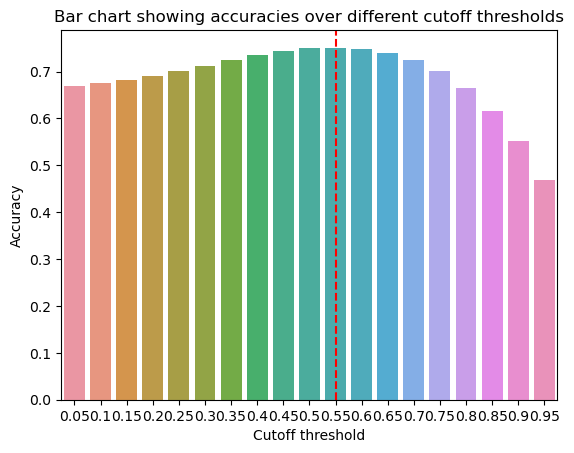

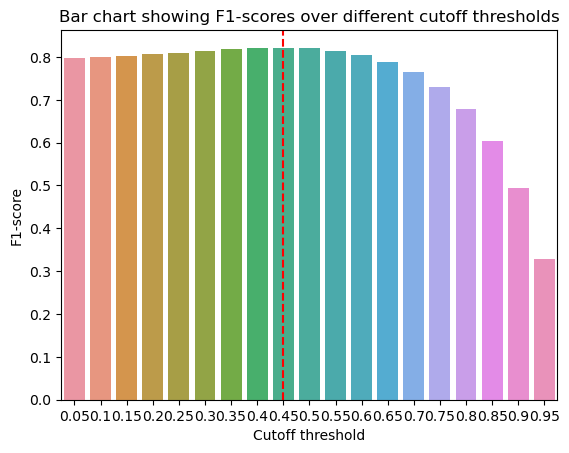

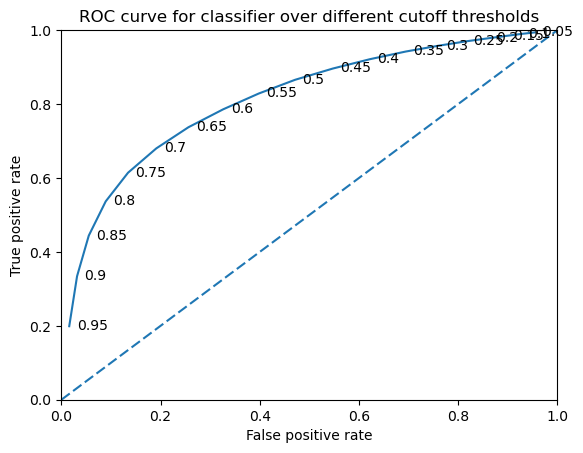

In [10]:
# Now we can evaluate the training
# ! We can actually also do some hyperparameter tuning (using ROC curves to determine the right cut-off probability) !

# Note ROC curves do not work well for linear regression, since there could be values that are not between 0 and 1!
# In this temporary example I just clip the predictions between 0 and 1

from metrics import confusion_matrix_statistics, LogisticRegressionLoss
import matplotlib.pyplot as plt
import seaborn as sns

num_values = 20
cutoff_values = [(i+1)/num_values for i in range(num_values-1)]

accuracies = []
f1_scores = []
tprs = []
fprs = []

for cutoff_value in cutoff_values:
    predictions = (LogisticRegressionLoss.sigmoid(X_test @ w) > cutoff_value).astype(np.int32)
    tp, fp, fn, tn, accuracy, tpr, _, f1_score, fpr = confusion_matrix_statistics(predictions, Y_test)
    accuracies.append(accuracy)
    f1_scores.append(f1_score)
    tprs.append(tpr)
    fprs.append(fpr)

plt.figure()
ax = sns.barplot(x=cutoff_values, y=accuracies)
largest_idx = np.argmax(accuracies)
plt.axvline(x=largest_idx, ymin=0, ymax=1, linestyle='dashed', color='red')
ax.set(title='Bar chart showing accuracies over different cutoff thresholds', xlabel='Cutoff threshold', ylabel='Accuracy')
plt.show()

plt.figure()
largest_idx = np.argmax(f1_scores)
plt.axvline(x=largest_idx, ymin=0, ymax=1, linestyle='dashed', color='red')
ax = sns.barplot(x=cutoff_values, y=f1_scores)
ax.set(title='Bar chart showing F1-scores over different cutoff thresholds', xlabel='Cutoff threshold', ylabel='F1-score')
plt.show()

plt.figure()
ax = sns.lineplot(x=fprs, y=tprs, legend=False)
ax.set(title='ROC curve for classifier over different cutoff thresholds', xlabel='False positive rate', ylabel='True positive rate', xlim=(0, 1), ylim=(0, 1))
ax.axline((0, 0), slope=1, dashes=(5, 2))
for i in range(len(tprs)):
    if i % math.ceil(0.05*len(cutoff_values)) == 0:
        plt.text(x=fprs[i]+0.015,y=tprs[i]-0.01, s=str(round(cutoff_values[i], 2)))
plt.show()

In [ ]:
# Testing linear regression
# Now we can do some training
from implementations import ridge_regression

X_train, X_test, Y_train, Y_test = train_test_split(X_train_public, Y_train_public, train_proportion=0.5)

w, loss = ridge_regression(Y_train, X_train, lambda_=0)
print('GD loss:', loss)
print('Weights:', w)

In [21]:
def plot_train_test(train_errors, test_errors, lambdas):
    """
    train_errors, test_errors and lambas should be list (of the same size) the respective train error and test error for a given lambda,
    * lambda[0] = 1
    * train_errors[0] = RMSE of a ridge regression on the train set
    * test_errors[0] = RMSE of the parameter found by ridge regression applied on the test set
    
    degree is just used for the title of the plot.
    """
    plt.semilogx(lambdas, train_errors, color='b', marker='*', label="Train error")
    plt.semilogx(lambdas, test_errors, color='r', marker='*', label="Test error")
    plt.xlabel("lambda")
    plt.ylabel("RMSE")
    plt.title("Ridge regression results")
    leg = plt.legend(loc=1, shadow=True)
    leg.draw_frame(False)

0.08536862758249683
proportion=0.5, lambda=0.000, Training RMSE=0.292, Testing RMSE=0.291
0.08538866185342295
proportion=0.5, lambda=0.000, Training RMSE=0.292, Testing RMSE=0.291
0.08540053827926924
proportion=0.5, lambda=0.000, Training RMSE=0.292, Testing RMSE=0.291
0.08540678258502273
proportion=0.5, lambda=0.000, Training RMSE=0.292, Testing RMSE=0.291
0.08541052730749392
proportion=0.5, lambda=0.000, Training RMSE=0.292, Testing RMSE=0.291
0.08541601264924956
proportion=0.5, lambda=0.001, Training RMSE=0.292, Testing RMSE=0.291
0.08543734865470193
proportion=0.5, lambda=0.001, Training RMSE=0.292, Testing RMSE=0.291
0.08554007581838494
proportion=0.5, lambda=0.003, Training RMSE=0.292, Testing RMSE=0.291
0.08602362086069926
proportion=0.5, lambda=0.007, Training RMSE=0.293, Testing RMSE=0.292
0.0880997232417023
proportion=0.5, lambda=0.016, Training RMSE=0.297, Testing RMSE=0.296
0.09567877323327648
proportion=0.5, lambda=0.037, Training RMSE=0.309, Testing RMSE=0.309
0.117144560

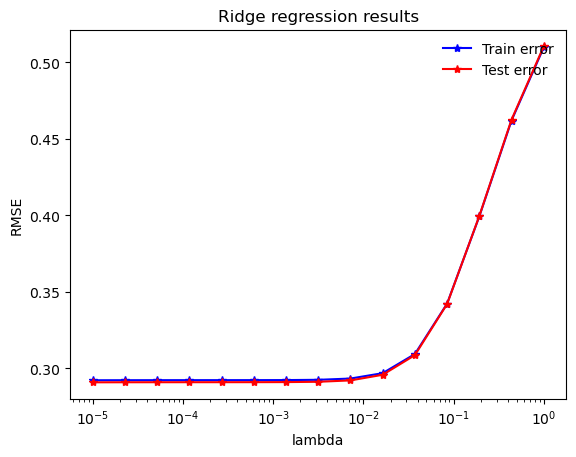

In [25]:
# Evaluating Ridge regression
from metrics import (
    RidgeLoss
)

def test_ridge_regression(x, y, ratio):
    
    lambdas = np.logspace(-5, 0, 15)
    x_tr, x_te, y_tr, y_te = train_test_split(x, y, train_proportion=ratio)
    rmse_tr = []
    rmse_te = []

    for ind, lambda_ in enumerate(lambdas):
        w, loss = ridge_regression(y_tr, x_tr, lambda_)
        rmse_tr.append(np.sqrt(loss))
        rmse_te.append(np.sqrt(RidgeLoss.loss(x_te, y_te, w)))

        print("proportion={p}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
                p=ratio, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
    
    plot_train_test(rmse_tr, rmse_te, lambdas)

test_ridge_regression(X_train_public, Y_train_public, 0.5)

For ridge regression the regularization does not seem to improve the test error. Thus, for ridge regression, using the standard linear regression is best for classification.

0.08487393185909352


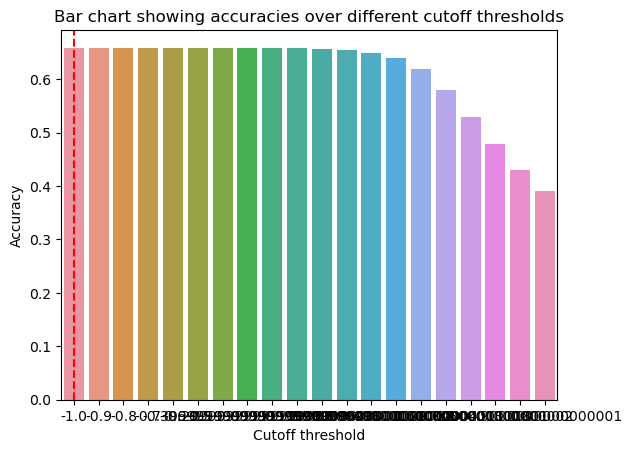

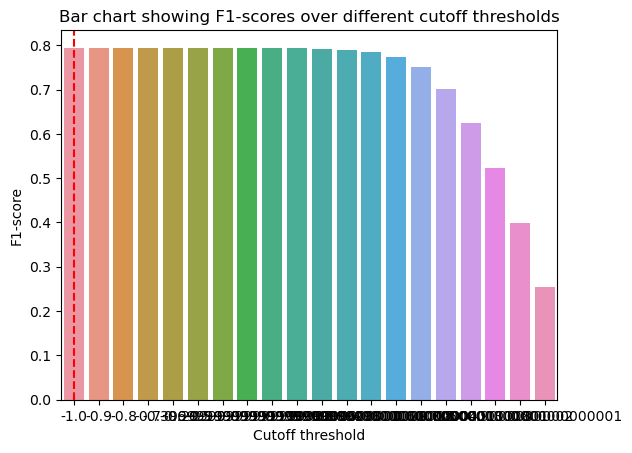

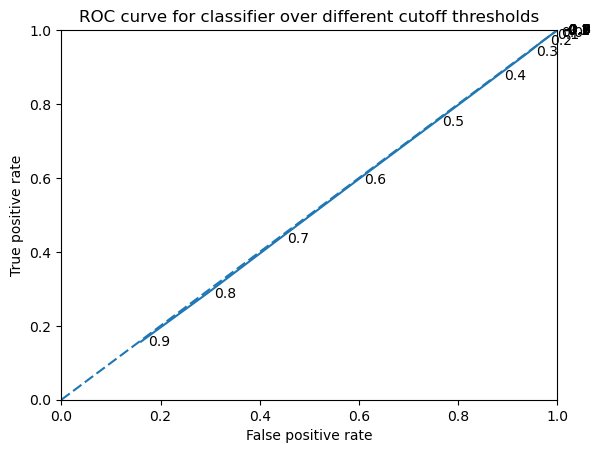

In [26]:
num_values = 20
cutoff_values = np.linspace(-1, 1, num=num_values, endpoint=False)

accuracies = []
f1_scores = []
tprs = []
fprs = []

x_tr, x_te, y_tr, y_te = train_test_split(X_train_public, Y_train_public, 0.5)
w, _ = ridge_regression(y_tr, x_tr, 0)

for cutoff_value in cutoff_values:
    predictions = (x_te @ w > cutoff_value).astype(np.int32)
    tp, fp, fn, tn, accuracy, tpr, _, f1_score, fpr = confusion_matrix_statistics(predictions, Y_test)
    accuracies.append(accuracy)
    f1_scores.append(f1_score)
    tprs.append(tpr)
    fprs.append(fpr)

plt.figure()
ax = sns.barplot(x=cutoff_values, y=accuracies)
largest_idx = np.argmax(accuracies)
plt.axvline(x=largest_idx, ymin=0, ymax=1, linestyle='dashed', color='red')
ax.set(title='Bar chart showing accuracies over different cutoff thresholds', xlabel='Cutoff threshold', ylabel='Accuracy')
plt.show()

plt.figure()
largest_idx = np.argmax(f1_scores)
plt.axvline(x=largest_idx, ymin=0, ymax=1, linestyle='dashed', color='red')
ax = sns.barplot(x=cutoff_values, y=f1_scores)
ax.set(title='Bar chart showing F1-scores over different cutoff thresholds', xlabel='Cutoff threshold', ylabel='F1-score')
plt.show()

plt.figure()
ax = sns.lineplot(x=fprs, y=tprs, legend=False)
ax.set(title='ROC curve for classifier over different cutoff thresholds', xlabel='False positive rate', ylabel='True positive rate', xlim=(0, 1), ylim=(0, 1))
ax.axline((0, 0), slope=1, dashes=(5, 2))
for i in range(len(tprs)):
    if i % math.ceil(0.05*len(cutoff_values)) == 0:
        plt.text(x=fprs[i]+0.015,y=tprs[i]-0.01, s=str(round(cutoff_values[i], 2)))
plt.show()

In [27]:
# Create predictions with linear regression
predictions = (X_test_public @ w > -1).astype(np.int32)

submission_file_name = 'submission_linregr_0.csv'
with open(os.path.join(data_directory, submission_file_name), mode='w', newline='', encoding='utf-8') as submission_file:
    writer = csv.writer(submission_file, delimiter=',')
    writer.writerow(['Id', 'Prediction'])
    for i, prediction in enumerate(predictions):
        writer.writerow([ids_test_public[i], 1 if prediction else -1])

# Inference

In [11]:
# Placeholder, array with True of False whether it belongs to the positive or negative sample
best_cutoff = 0.35

predictions = (LogisticRegressionLoss.sigmoid(X_test_public @ w) > best_cutoff).astype(np.int32)

submission_file_name = 'submission_0.csv'
with open(os.path.join(data_directory, submission_file_name), mode='w', newline='', encoding='utf-8') as submission_file:
    writer = csv.writer(submission_file, delimiter=',')
    writer.writerow(['Id', 'Prediction'])
    for i, prediction in enumerate(predictions):
        writer.writerow([ids_test_public[i], 1 if prediction else -1])
